Questions: 
    
    1. Yellowbrick viz doesn't work

In [6]:
import pandas as pd
import numpy as np
import matplotlib as plt
import pandas as pd
import datetime
from datetime import timedelta
from collections import Counter
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [7]:
from google.colab import files
uploaded = files.upload()

Saving takehome_user_engagement.csv to takehome_user_engagement (1).csv


In [8]:
from google.colab import files
uploaded = files.upload()

Saving takehome_users.csv to takehome_users (1).csv


In [9]:
user_engage = pd.read_csv('takehome_user_engagement.csv')
user_info = pd.read_csv('takehome_users.csv', encoding="ISO-8859-1") 

# Data Wrangling 

In [10]:
user_engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [11]:
user_engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [12]:
user_engage['user_id'].value_counts()

3623     606
906      600
1811     593
7590     590
8068     585
        ... 
6763       1
3773       1
5822       1
10040      1
2047       1
Name: user_id, Length: 8823, dtype: int64

In [13]:
user_engage['visited'].value_counts()

1    207917
Name: visited, dtype: int64

In [14]:
user_info.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [15]:
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


Change last_session_creation_time in user_engage to timestamp/datetime object

In [16]:
# converting apropriate columns to date time objects.
user_info.creation_time = pd.to_datetime(user_info.creation_time)
#users.last_session_creation_time = pd.to_datetime(users.last_session_creation_time, unit='s')
user_engage.time_stamp = pd.to_datetime(user_engage.time_stamp)

Check types of changes features

In [17]:
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


In [18]:
user_engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


Two columns have missing values - last session creation time and invited by user id. For the missing values, we can just fill in 0 for the further analysis pusposes.

In [19]:
users = user_info.fillna(0)

In [20]:
def login(input_time):
    """Determine if the user visited the page based on the presence of last session creation time."""
    if input_time==0:
        return 1
    else:
        return 0

users['logged_in']=users.last_session_creation_time.apply(login)

In [21]:
user_engage['week-year'] = user_engage['time_stamp'].dt.strftime('%U-%Y')
engage = user_engage.groupby(['user_id', 'week-year']).size().reset_index().rename(columns={0:'count'})
engage.head()

,user_id,week-year,count
0,1,16-2014,1
1,2,01-2014,1
2,2,05-2014,2
3,2,06-2014,2
4,2,07-2014,1


In [22]:
adopted_id = engage[engage['count'] >=3]['user_id'].unique()
len(adopted_id)

1432

We calculated how many people logged into the product on three separate days in at least one seven day period (a week) - these were the adopted users. There are in total 1432 adopted users.

# Exploratory Data Analysis

In [23]:
import pandas as pd
import numpy as np
import sklearn
from scipy import stats
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [24]:
def adopted(user_id):
    """Function to classify an user as adopted, based on the list of adoptd users provided."""
    if user_id in adopted_id:
        return 1
    else:
        return 0

users['adopted']=users.object_id.apply(adopted)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Counts of Adopted and Non Adopted Users')

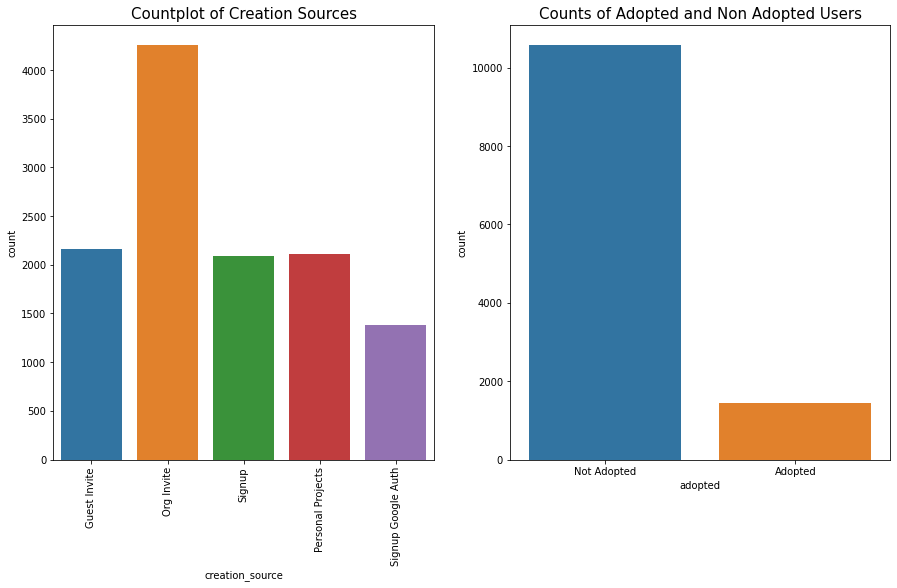

In [25]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
sns.countplot(users.creation_source, ax=ax1)
ax1.set_xticklabels(['Guest Invite', 'Org Invite', 'Signup', 'Personal Projects', 'Signup Google Auth'],rotation=90)
ax1.set_title('Countplot of Creation Sources',fontsize=15)

sns.countplot(users.adopted, ax=ax2)
ax2.set_xticklabels(['Not Adopted', 'Adopted'])
ax2.set_title('Counts of Adopted and Non Adopted Users', fontsize=15)

Most of the users joined via oragnization invite.
The number of adopted users is a lot lower than the non-adopted ones.

# Modeling

The next step preparing the data for fitting machine learning classification model. I will drop the columns which will not affect the modelling, and one hot encode the categorical features as required.

In [26]:
users = users.drop(['creation_time','name','email','last_session_creation_time'],1)

In [27]:
cs_onehot_features = pd.get_dummies(users['creation_source'])
users=pd.concat([users, cs_onehot_features], axis=1)
users = users.drop(['creation_source'],1)
users.head()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,logged_in,adopted,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,1,0,11,10803.0,0,0,1,0,0,0,0
1,2,0,0,1,316.0,0,0,0,1,0,0,0
2,3,0,0,94,1525.0,0,0,0,1,0,0,0
3,4,0,0,1,5151.0,0,0,1,0,0,0,0
4,5,0,0,193,5240.0,0,0,1,0,0,0,0


I will use gradient boosting classifier to classify adopted users based on the different features. And try to find which  features are the most important in determining whether a user becomes an adopted user.

In [28]:
from sklearn.ensemble import GradientBoostingClassifier

X = users.drop('adopted', axis=1)
y = users.adopted

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

model = GradientBoostingClassifier()
model.fit(X_train, y_train)
print('Testing score: ',model.score(X_test, y_test))

Testing score:  0.8836111111111111


In [29]:
from sklearn.datasets import make_regression
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

#https://machinelearningmastery.com/calculate-feature-importance-with-python/
#find an easier way to do feature importance
#LOOK AT SKIING FOR FEATURE IMPORTANCE !! 

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

NameError: ignored

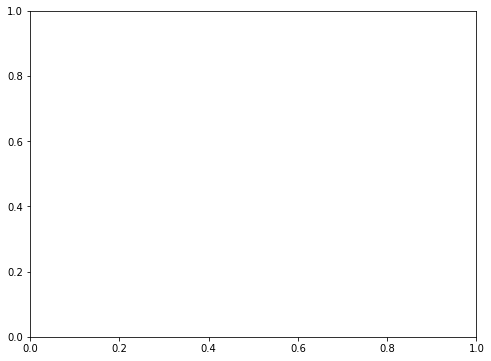

In [35]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()

gbc_features = FeatureImportances(GradientBoostingClassifier(), ax=ax)
gbc_features.fit(X, y)
gbc_features.poof()

# Summary

We got a score of about 0.88 while solving the classification problem using the gradient boosting classifier. 
The top three important features were:....